In [ ]:
!pip install --upgrade nltk

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
!pip install -U pandas

# 0. Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import Counter

import math
from math import radians, sin, cos, asin, sqrt

import re
from re import findall
import datetime as dt

# для нормализации, стандартизации
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.max_columns', 200)  # показывать больше колонок

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Загружаем лингвистические библиотеки для обработки тестов отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/daria/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
TARGET_NAME = 'reviewer_score'

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Import datasets

In [4]:
# Подгрузим наши данные из соревнования

df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

In [5]:
print(df_train.info())
df_train.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [6]:
print(df_test.info())
df_test.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [7]:
print(sample_submission.info())
sample_submission.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB
None


,reviewer_score,id
0,1,488440
1,10,274649


# 2. EDA

## 2.0. Functions, dictionaries and constants

In [8]:
# функция создает единый список из списков
def list_unrar(list_of_lists):
    result=[]
    for lst in list_of_lists:
        result.extend(lst)
    return result

In [9]:
# Словари с с пропущенными координатами по адресам отелей
lat_dict = {'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': 48.215178,
       '23 Rue Damr mont 18th arr 75018 Paris France': 48.884582,
       'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': 48.209650,
       'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': 48.220269,
       '4 rue de la P pini re 8th arr 75008 Paris France': 48.856818,
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': 48.245892,
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': 48.213559,
       'Bail n 4 6 Eixample 08010 Barcelona Spain': 41.391967,
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': 48.207911,
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': 48.194113,
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria': 48.163757,
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': 48.216778,
       '20 Rue De La Ga t 14th arr 75014 Paris France': 48.856818,
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': 48.208174,
       'Sep lveda 180 Eixample 08011 Barcelona Spain': 41.384733,
       'Pau Clar s 122 Eixample 08009 Barcelona Spain': 41.392789,
       'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': 48.209580}
lng_dict = {'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': 16.303380,
       '23 Rue Damr mont 18th arr 75018 Paris France': 2.324640,
       'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': 16.353160,
       'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': 16.355809,
       '4 rue de la P pini re 8th arr 75008 Paris France': 2.304722,
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': 16.341939,
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': 16.380100,
       'Bail n 4 6 Eixample 08010 Barcelona Spain': 2.175728,
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': 16.394933,
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': 16.395356,
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria': 16.445799,
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': 16.360074,
       '20 Rue De La Ga t 14th arr 75014 Paris France': 2.304722,
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': 16.373819,
       'Sep lveda 180 Eixample 08011 Barcelona Spain': 2.160988,
       'Pau Clar s 122 Eixample 08009 Barcelona Spain': 2.167397,
       'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria':16.351433}

In [10]:
# население согласно Википедии, тыс.чел
population_dict = {'United_Kingdom': 8962, 'Paris_France': 2148, 'Amsterdam_Netherlands': 873,
                   'Milan_Italy': 1379, 'Vienna_Austria': 1897, 'Barcelona_Spain': 1636}
# плотность населения, тыс. чел на км
pop_density_dict = {'United_Kingdom': 5.7, 'Paris_France': 20.8, 'Amsterdam_Netherlands': 4.8,
                   'Milan_Italy': 7.6, 'Vienna_Austria': 4.5, 'Barcelona_Spain': 15.8}

In [11]:
# списки 10 самых популярных отелей и национальностей ревьюверов
top_10_nationalities = ['united_kingdom', 'united_states_of_america', 'australia', 'ireland',
                       'united_arab_emirates', 'saudi_arabia', 'netherlands', 'switzerland',
                       'germany', 'canada']
top_10_hotels = ['Britannia_International_Hotel_Canary_Wharf', 'Strand_Palace_Hotel',
                'Park_Plaza_Westminster_Bridge_London', 'Copthorne_Tara_Hotel_London_Kensington', 
                 'DoubleTree_by_Hilton_Hotel_London_Tower_of_London', 'Grand_Royale_London_Hyde_Park',
                 'Holiday_Inn_London_Kensington', 'Hilton_London_Metropole', 
                 'Millennium_Gloucester_Hotel_London', 'Intercontinental_London_The_O2']

In [12]:
def code_data(df: pd.DataFrame) -> pd.DataFrame:
    """Функция кодирует признаки датафрейма.

    Args:
        df (pd.DataFrame): датафрейм до кодирования

    Returns:
        pd.DataFrame: датафрейм с закодированными признаками
    """

    # Списки для названий признаков для двух типов кодирования
    one_hot_cols = []
    binary_cols = []

    # Пройдемся по всем категориальным признакам и сохраним их в списки
    for col in df.columns:
        if df[col].dtype == 'object':
            if df[col].nunique() > 15: # если кол-во значений > 15
                binary_cols.append(col)
            else:                      # если меньше или равно 15
                one_hot_cols.append(col)

    # Выполним однократное кодирование признаков
    encoder = ce.OneHotEncoder(cols=one_hot_cols, use_cat_names=True)
    type_bin = encoder.fit_transform(df[one_hot_cols])
    df = pd.concat([df, type_bin], axis=1)
    df.drop(one_hot_cols, axis=1, inplace=True)

    # Выполним двоичное кодирование признаков
    bin_encoder = ce.BinaryEncoder(cols=binary_cols)
    type_bin = bin_encoder.fit_transform(df[binary_cols])
    df = pd.concat([df, type_bin], axis=1)
    df.drop(binary_cols, axis=1, inplace=True)
    
    #Вернем датафрейм
    return df

In [13]:
# функция определения расстояния до центра города 

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    earth_radius = 6371 
    return round(c*earth_radius)


In [36]:
# функция для нормализации, компенсирующая выбросы
def RobustScaler_column(d_col):
    rscaler = RobustScaler()
    rscaler.fit(preproc_df[[d_col]])
    return rscaler.transform(preproc_df[[d_col]])

In [37]:
# функция для стандартизации,
def MinMaxScaler_column(d_col):
    mscaler = preprocessing.MinMaxScaler()
    mscaler.fit(preproc_df[[d_col]])
    return mscaler.transform(preproc_df[[d_col]])

In [16]:
def join_df(train_df, test_df: pd.DataFrame) -> pd.DataFrame:
    """Функция объединяет тренировочную и тестовую выборки.
    Индекс при этом сохраняется.

    Args:
        train_df (_type_): тренировочный датафрейм
        test_df (pd.DataFrame): тестовый датафрейм

    Returns:
        pd.DataFrame: объединенный датафрейм
    """

    test_df['reviewer_score'] = -1 # добавим недостающий столбец
    combined_df = pd.concat([train_df, test_df], axis=0)

    # Вернем объединенный датафрейм
    return combined_df



In [17]:
def split_df(preproc_data: pd.DataFrame, ind:int=386803) -> tuple:
    """Функция разделяет датафрейм на два по индексу.

    Args:
        combined_df (pd.DataFrame): объединенный датафрейм
        ind (int, optional): индекс разделения

    Returns:
        tuple: кортеж из датафреймов
    """

    train_df = preproc_data.iloc[:ind, :]
    test_df = preproc_data.iloc[ind:, :]
    test_df = test_df.drop('reviewer_score', axis=1) #  удалим столбец из тестовой выборки

    # Вернем разделенные датафреймы
    return train_df, test_df

## 2.1. Join datasets for EDA

In [19]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
data = join_df(df_train, df_test)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## 2.2. Missing values

In [21]:
hotels_eda = data.copy()

In [22]:
hotels_eda.hotel_address[hotels_eda.lat.isna()].nunique()

17

всего 17 значений адресов без координат, добавлю их вручную, воспользовавшись онлайн ресурсом u-karty.ru

In [23]:
hotels_eda['lat'] = hotels_eda['lat'].fillna(hotels_eda['hotel_address'].map(lat_dict))
hotels_eda['lng'] = hotels_eda['lng'].fillna(hotels_eda['hotel_address'].map(lng_dict))

## 2.3. Nunique/correlations

Оценим количество уникальных значений в признаках

In [24]:
hotels_eda.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
reviewer_score                                    38
tags                                           55242
days_since_review                                731
lat                                             1488
lng                                             1488
dtype: int64

In [25]:
# Очистим от лишних пробелов и заменим пропуски на _ в названиях отелей и национальности ревьювера
hotels_eda.reviewer_nationality = hotels_eda.reviewer_nationality.apply(lambda x: x.strip())
hotels_eda.reviewer_nationality = hotels_eda.reviewer_nationality.str.lower().str.replace(' ', '_', regex=True)
hotels_eda.hotel_name = hotels_eda.hotel_name.str.replace(' ', '_', regex=True)

In [27]:
# создам словари с количеством отзывов у отеля по его названию и по национальности ревьювера
hot_name_count_dict = dict(hotels_eda.hotel_name.value_counts())
dict(hotels_eda.hotel_name.value_counts().nlargest(10))

{'Britannia_International_Hotel_Canary_Wharf': 4789,
 'Strand_Palace_Hotel': 4256,
 'Park_Plaza_Westminster_Bridge_London': 4169,
 'Copthorne_Tara_Hotel_London_Kensington': 3578,
 'DoubleTree_by_Hilton_Hotel_London_Tower_of_London': 3212,
 'Grand_Royale_London_Hyde_Park': 2958,
 'Holiday_Inn_London_Kensington': 2768,
 'Hilton_London_Metropole': 2628,
 'Millennium_Gloucester_Hotel_London': 2565,
 'Intercontinental_London_The_O2': 2551}

In [28]:
rev_nat_count_dict = dict(hotels_eda.reviewer_nationality.value_counts())
dict(hotels_eda.reviewer_nationality.value_counts().nlargest(10))

{'united_kingdom': 245246,
 'united_states_of_america': 35437,
 'australia': 21686,
 'ireland': 14827,
 'united_arab_emirates': 10235,
 'saudi_arabia': 8951,
 'netherlands': 8772,
 'switzerland': 8678,
 'germany': 7941,
 'canada': 7894}

In [29]:
# составлю списки 10 самых популярных значений
top_10_nationalities = ['united_kingdom', 'united_states_of_america', 'australia', 'ireland',
                       'united_arab_emirates', 'saudi_arabia', 'netherlands', 'switzerland',
                       'germany', 'canada']
top_10_hotels = ['Britannia_International_Hotel_Canary_Wharf', 'Strand_Palace_Hotel',
                'Park_Plaza_Westminster_Bridge_London', 'Copthorne_Tara_Hotel_London_Kensington', 
                 'DoubleTree_by_Hilton_Hotel_London_Tower_of_London', 'Grand_Royale_London_Hyde_Park',
                 'Holiday_Inn_London_Kensington', 'Hilton_London_Metropole', 
                 'Millennium_Gloucester_Hotel_London', 'Intercontinental_London_The_O2']

Также посмотрим на таблицу корреляции признаков

<AxesSubplot: >

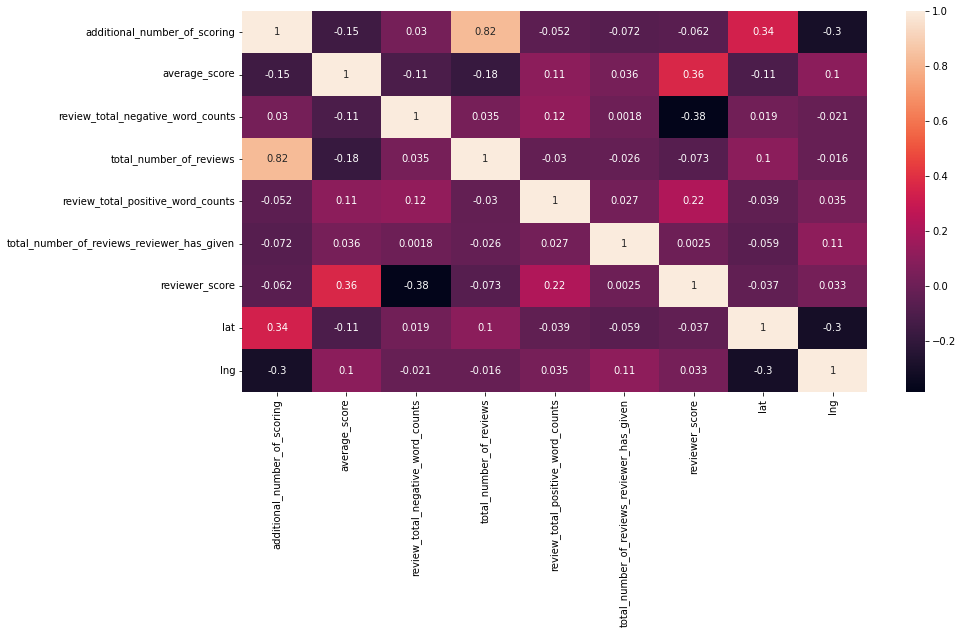

In [30]:
mask_no_test = hotels_eda.reviewer_score > -1
plt.rcParams['figure.figsize'] = (14,7)
plt.xticks(rotation=45)
sns.heatmap(hotels_eda[mask_no_test].corr(), annot=True)

## 2.4. Outliers

In [31]:
# Использование метода describe()
hotels_eda[mask_no_test].describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,386803.000000,386803.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.433430,2.892393
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.460952,4.666227
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214066,-0.143372
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,0.019886
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.841163
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.445799


### 2.4.1. распределение additional_number_of_scoring

<AxesSubplot: xlabel='additional_number_of_scoring'>

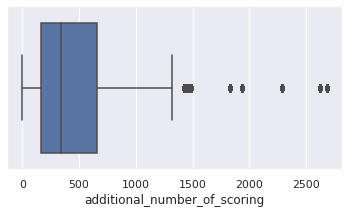

In [32]:
sns.set_theme()
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(data=hotels_eda, x='additional_number_of_scoring')

<AxesSubplot: >

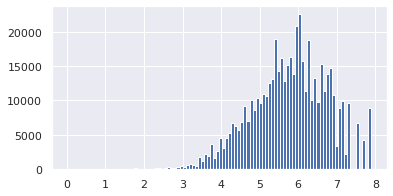

In [33]:
# посмотрим как нормализует переменную логарифмирование
np.log(hotels_eda.additional_number_of_scoring).hist(bins = 100)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot: xlabel='additional_number_of_scoring', ylabel='reviewer_score'>

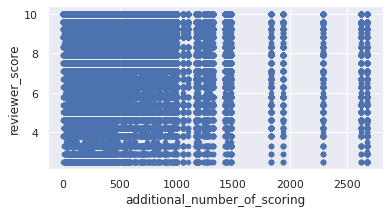

In [34]:
#  ну и заодно глянем на диаграмму рассеивания
hotels_eda[mask_no_test].plot(x='additional_number_of_scoring', y='reviewer_score', kind='scatter')

### 2.4.2. распределение average_score

<AxesSubplot: xlabel='average_score'>

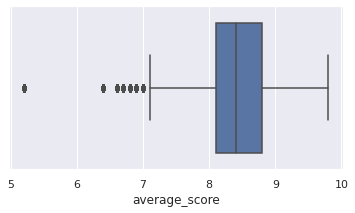

In [35]:
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(data=hotels_eda, x='average_score')

<AxesSubplot: >

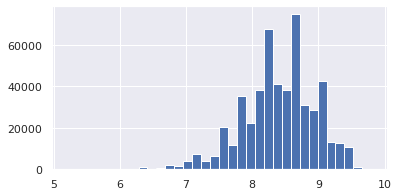

In [36]:
hotels_eda.average_score.hist(bins = 34)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot: xlabel='average_score', ylabel='reviewer_score'>

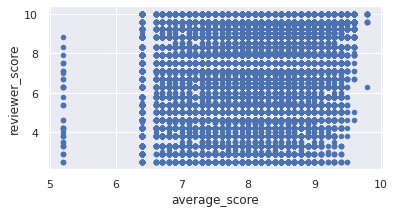

In [37]:
# диаграмма рассеивания
hotels_eda[mask_no_test].plot(x='average_score', y='reviewer_score', kind='scatter')

### 2.4.3. распределение review_total_negative_word_counts

0      127890
2       24647
3       18144
6       17749
5       16809
        ...  
400         1
331         1
398         1
408         1
401         1
Name: review_total_negative_word_counts, Length: 402, dtype: int64


<AxesSubplot: xlabel='review_total_negative_word_counts'>

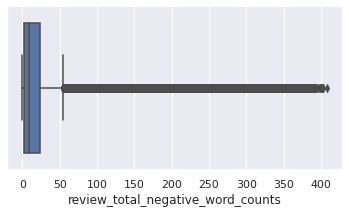

In [38]:
print(hotels_eda.review_total_negative_word_counts.value_counts())
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(data=hotels_eda, x='review_total_negative_word_counts')

<AxesSubplot: >

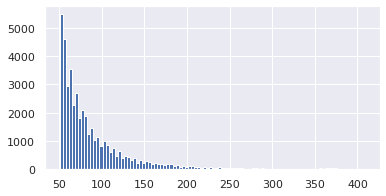

In [39]:
mask_many_negative = hotels_eda.review_total_negative_word_counts > 50
hotels_eda[mask_many_negative].review_total_negative_word_counts.hist(bins = 100)

<AxesSubplot: >

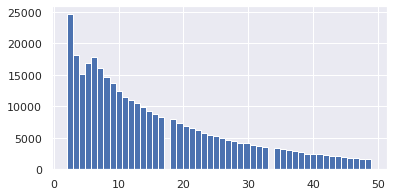

In [40]:
# посмотрю на распределение без нулевых и многословных отзывов
mask_no_zero = hotels_eda.review_total_negative_word_counts > 0
mask_normal_negative = hotels_eda.review_total_negative_word_counts < 50
hotels_eda[mask_no_zero & mask_normal_negative].review_total_negative_word_counts.hist(bins = 50)

In [41]:
# посмотрю сколько вообще нулевых значений
mask_zero_negativ = hotels_eda.review_total_negative_word_counts == 0
hotels_eda[mask_zero_negativ].review_total_negative_word_counts.info()

<class 'pandas.core.series.Series'>
Int64Index: 127890 entries, 3 to 128933
Series name: review_total_negative_word_counts
Non-Null Count   Dtype
--------------   -----
127890 non-null  int64
dtypes: int64(1)
memory usage: 2.0 MB


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot: xlabel='review_total_negative_word_counts', ylabel='reviewer_score'>

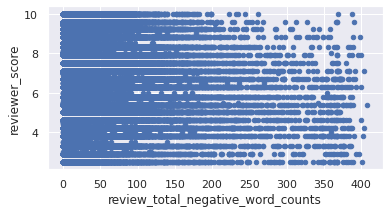

In [42]:
# диаграмма рассеивания
hotels_eda[mask_no_test].plot(x='review_total_negative_word_counts', y='reviewer_score', kind='scatter')

### 2.4.4. распределение total_number_of_reviews

<AxesSubplot: xlabel='total_number_of_reviews'>

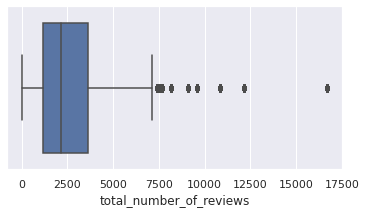

In [43]:
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(data=hotels_eda, x='total_number_of_reviews')

<AxesSubplot: >

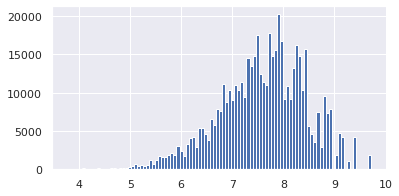

In [44]:
# посмотрим как нормализует переменную логарифмирование
np.log(hotels_eda.total_number_of_reviews).hist(bins = 100)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot: xlabel='total_number_of_reviews', ylabel='reviewer_score'>

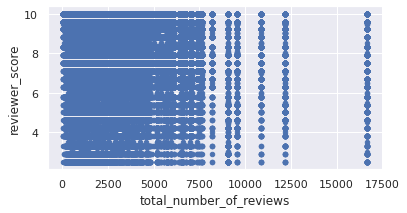

In [45]:
# диаграмма рассеивания
hotels_eda[mask_no_test].plot(x='total_number_of_reviews', y='reviewer_score', kind='scatter')

### 2.4.5. распределение review_total_positive_word_counts

<AxesSubplot: xlabel='review_total_positive_word_counts'>

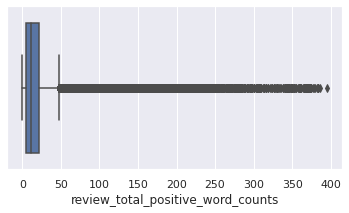

In [46]:
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(data=hotels_eda, x='review_total_positive_word_counts')

<AxesSubplot: >

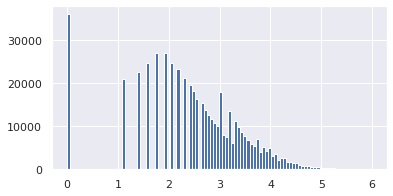

In [47]:
np.log(hotels_eda.review_total_positive_word_counts+1).hist(bins=100)

интересненько, картина похожая с негативными словами, как будто 3 группы наложенных распределений - нулевые, до 50 слов и более 50 слов

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot: xlabel='review_total_positive_word_counts', ylabel='reviewer_score'>

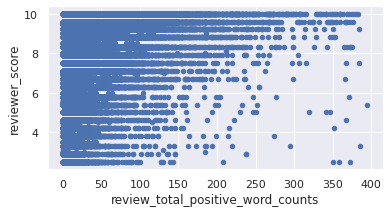

In [48]:
# диаграмма рассеивания
hotels_eda[mask_no_test].plot(x='review_total_positive_word_counts', y='reviewer_score', kind='scatter')

### 2.4.6. распределение total_number_of_reviews_reviewer_has_given

<AxesSubplot: xlabel='total_number_of_reviews_reviewer_has_given'>

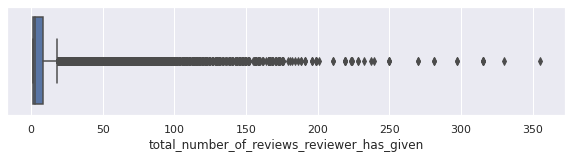

In [49]:
plt.rcParams['figure.figsize'] = (10,2)
sns.boxplot(data=hotels_eda, x='total_number_of_reviews_reviewer_has_given')

<AxesSubplot: >

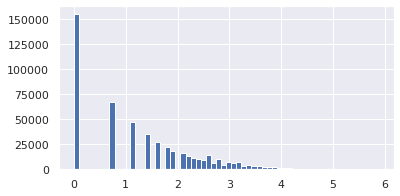

In [50]:
# посмотрим как нормализует переменную логарифмирование
plt.rcParams['figure.figsize'] = (6,3)
np.log(hotels_eda.total_number_of_reviews_reviewer_has_given).hist(bins = 60)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot: xlabel='total_number_of_reviews_reviewer_has_given', ylabel='reviewer_score'>

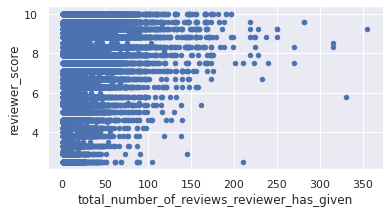

In [51]:
# диаграмма рассеивания
hotels_eda[mask_no_test].plot(x='total_number_of_reviews_reviewer_has_given', 
                              y='reviewer_score', kind='scatter')

## 2.5. Feature engineering

### 2.5.1. Добавим признак расстояние до Парижа

In [52]:
fe_data = hotels_eda.copy()
fe_data['distance'] = fe_data.apply(lambda row: 
                                      haversine(lon1, 
                                                lat1,
                                                lon2 = row['lng'], 
                                                lat2 = row['lat']), 
                                      axis=1)
# по сути признак с расстоянием описывает наши координаты, можем исходные широты/долготы удалить
fe_data.drop(['lat', 'lng'], axis=1, inplace=True)
print(fe_data['distance'].describe())
fe_data.sample(2)

count    515738.000000
mean        444.054477
std         272.075164
min           0.000000
25%         343.000000
50%         346.000000
75%         638.000000
max        1040.000000
Name: distance, dtype: float64


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,distance
73193,Via Giovanni Nicotera 9 Niguarda 20161 Milan I...,102,10/25/2015,8.5,Acca_Palace,vietnam,No Negative,0,1886,Nice friendly staff Location is good if you w...,40,3,8.8,"[' Leisure trip ', ' Family with young childre...",648 day,635
90559,265 Rotherhithe Street Southwark London SE16 5...,995,12/23/2015,8.1,DoubleTree_by_Hilton_London_Docklands_Riverside,united_kingdom,No Negative,0,3826,The staff were very nice and polite willing t...,16,4,9.6,"[' Leisure trip ', ' Couple ', ' Queen Guest R...",589 day,340


In [71]:
fe_data.distance.nunique()

72

Как видим, весь наш большой датасет сводится к 72 локациям, как раз не далее 1040км от Парижа

### 2.5.2. Поработаем с датами

In [53]:
# fe_data = hotels_eda.copy()
# преобразуем тип признака с датой
fe_data.review_date =  pd.to_datetime(fe_data.review_date)
# создам признак с периодом между самым новым и самым старым отзывом по адресу отеля
grp_name = fe_data.groupby(['hotel_address']).review_date.max() - fe_data.groupby(['hotel_address']).review_date.min()
fe_data['date_diff'] = fe_data.hotel_address.apply(lambda x: grp_name[x]).dt.days
# преобразуем признак days_since_review в числовой
fe_data['days_since_review'] = pd.to_numeric(fe_data['days_since_review'].str.replace('\D', ''), errors='coerce')
# выделю из даты отзыва является ли выходным днем
fe_data['is_weekend'] = fe_data.review_date.dt.weekday.apply(lambda x: 1 if x > 4 else 0)
# выделю из даты отзыва день недели
fe_data['wd'] = fe_data.review_date.dt.weekday
# выделю из даты отзыва число месяца
fe_data['md'] = fe_data.review_date.dt.month
# удалю дату отзыва
fe_data.drop('review_date', axis=1, inplace=True)
print(fe_data.info())
fe_data.sample(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,distance,date_diff,is_weekend,wd,md
361229,372 Strand Westminster Borough London WC2R 0JJ...,2288,8.1,Strand_Palace_Hotel,malta,although clean and just about airy enough the...,70,9568,the location is excellent the staff very cour...,45,1,6.7,"[' Leisure trip ', ' Solo traveler ', ' Standa...",413,344,730,0,3,6
17839,Lepanto 406 Horta Guinard 08025 Barcelona Spain,35,7.9,Ilunion_Bel_Art,united_kingdom,Nothing to dislike,4,353,It was very clean quiet,7,1,-1.0,"[' Family with young children ', ' Double or T...",40,828,151,1,5,6


Посмотрю распределения синтезированных признаков

<AxesSubplot: >

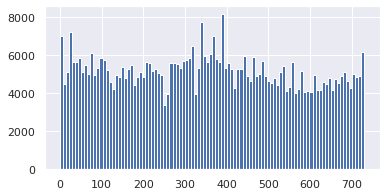

In [54]:
# количество дней после отзыва
fe_data.days_since_review.hist(bins=100)

<AxesSubplot: >

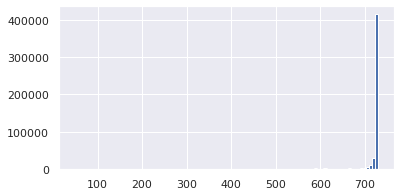

In [55]:
fe_data.date_diff.hist(bins=100)

<AxesSubplot: >

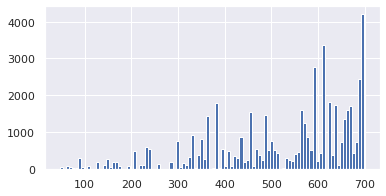

In [56]:
# менее 700 дней между самым старым и свежим отзывами по отношению к адресу
mask_1 = fe_data.date_diff < 700
fe_data[mask_1].date_diff.hist(bins=100)

<AxesSubplot: >

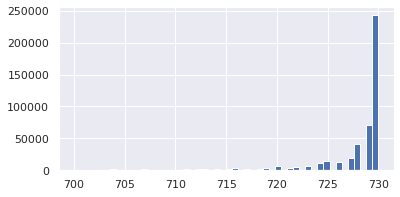

In [57]:
# от 700 и более дней между отзывами по адресу
mask_2 = fe_data.date_diff > 699
fe_data[mask_2].date_diff.hist(bins=50)

Около половины всех значений имеют максимальную разницу между самым первым и самым последним отзывами - 730 дней. Кто бы знал, что это может значить

<AxesSubplot: >

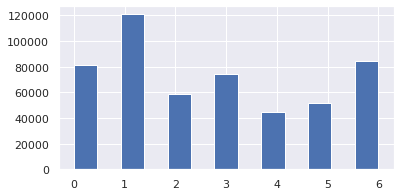

In [58]:
# распределение отзывов по дням недели, 0 - понедельник
fe_data.wd.hist(bins=13)

чаще всего находит вдохновение написать к отелю отзыв по вторникам?

<AxesSubplot: >

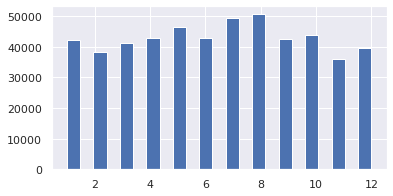

In [59]:
# распределение отзывов по месяцам
fe_data.md.hist(bins=23)

похоже что самые "горячие" для отелей месяцы - май, июль и август, а самый спокойным - ноябрь. Выглядит вполне логично

### 2.5.3. Обработаем тэги

In [60]:
#fe_data = hotels_eda.copy()
print(fe_data.tags[0])
# переведем признак с тэгами в список
fe_data.tags = fe_data.tags.str.findall(r"' (\b.*?\b) '")
# создам признак с количеством тегов
fe_data['сount_tags'] = fe_data.tags.apply(lambda x: len(x))

# обработаю теги с использованием библиотеки Counter
temp_list = fe_data.tags.tolist()
temp_Counter = Counter(list_unrar(temp_list))
dict_tags = dict(temp_Counter)
print('Количество уникальных тегов: ', len(list(temp_Counter)))

# имеем 2428 тегов, разделим их на категории по популярности
# список самых популярных тегов
list_of_most_popular_tag = [x[0] for x in temp_Counter.most_common(15)]
# список популярных тегов
list_of_popular_tag = [x[0] for x in temp_Counter.most_common()[15:600]]
# список редких тегов
list_of_rare_tag = [x[0] for x in temp_Counter.most_common()[600:]]
# проверю все ли тэги учла в списках
print('Tag lists sum: ', (len(list_of_most_popular_tag)+len(list_of_popular_tag)+len(list_of_rare_tag)))
# создам признаки на основе популярности тегов
fe_data['rare_tag'] = fe_data.tags.apply(lambda x: 1 if len(set(x) & set(list_of_rare_tag))>0  else 0).astype('float64')
fe_data['popular_tag'] = hotels_eda.tags.apply(lambda x: 1 if len(set(x) & set(list_of_popular_tag))>0  else 0).astype('float64')

# а самые популярные 15 тегов выведем в отдельные категории
for tag in list_of_most_popular_tag:
    fe_data[tag] = fe_data.tags.apply(lambda x: 1 if tag in x else 0 ).astype('float64')

# уберу пробелы в названиях колонок
fe_data.columns = [column.replace(' ','_') for column in fe_data.columns]
print(fe_data.info())
fe_data.sample(2)

0    [' Leisure trip ', ' Couple ', ' Studio Suite ...
0    [' Leisure trip ', ' Couple ', ' Double Room '...
Name: tags, dtype: object
Количество уникальных тегов:  2428
Tag lists sum:  2428
<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews   

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,distance,date_diff,is_weekend,wd,md,сount_tags,rare_tag,popular_tag,Leisure_trip,Submitted_from_a_mobile_device,Couple,Stayed_1_night,Stayed_2_nights,Solo_traveler,Stayed_3_nights,Business_trip,Group,Family_with_young_children,Stayed_4_nights,Double_Room,Standard_Double_Room,Superior_Double_Room,Family_with_older_children
98161,4 18 Harrington Gardens Kensington and Chelsea...,1444,7.8,Millennium_Gloucester_Hotel_London,gibraltar,The shower had no pressure The shower head wa...,72,5726,No Positive,0,7,-1.0,"[Business trip, Solo traveler, Standard Twin R...",658,344,730,0,3,10,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112007,140 Park Lane Westminster Borough London W1K 7...,53,8.8,London_Marriott_Hotel_Park_Lane,united_arab_emirates,limited food choices for breakfast in executi...,19,213,The Qibla prayer direction is there without I...,29,2,-1.0,"[Leisure trip, Couple, Executive King or Twin ...",450,345,472,0,1,5,5,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


count    515738.000000
mean          4.569359
std           0.520187
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           6.000000
Name: сount_tags, dtype: float64


<AxesSubplot: >

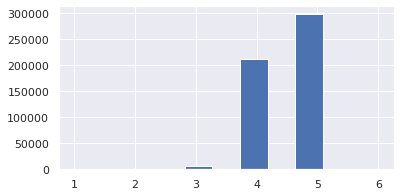

In [61]:
print(fe_data['сount_tags'].describe())
fe_data['сount_tags'].hist(bins = 11)

In [62]:
fe_data['сount_tags'].value_counts()

5    297823
4    211564
3      5505
6       755
2        85
1         6
Name: сount_tags, dtype: int64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot: xlabel='сount_tags', ylabel='reviewer_score'>

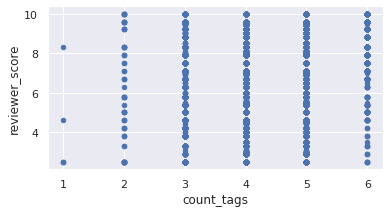

In [63]:
# диаграмма рассеивания
fe_data[mask_no_test].plot(x='сount_tags', y='reviewer_score', kind='scatter')

### 2.5.4. Обработаем тексты отзывов

In [64]:
#fe_data = hotels_eda.copy()

sid = SentimentIntensityAnalyzer()

fe_data['neg_scores'] = fe_data['negative_review'].apply(lambda review: sid.polarity_scores(review))
fe_data['pos_scores'] = fe_data['positive_review'].apply(lambda review: sid.polarity_scores(review))

fe_data['neg_compound']  = fe_data['neg_scores'].apply(lambda score_dict: score_dict['compound'])
fe_data['pos_compound']  = fe_data['pos_scores'].apply(lambda score_dict: score_dict['compound'])

fe_data['neg_comp_score'] = fe_data['neg_compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
fe_data['pos_comp_score'] = fe_data['pos_compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

print(fe_data['neg_compound'].describe())
print(fe_data['pos_compound'].describe())
print(fe_data['neg_comp_score'].describe())
print(fe_data['pos_comp_score'].describe())

fe_data.sample(3)

count    515738.000000
mean         -0.209151
std           0.453386
min          -0.998100
25%          -0.709600
50%          -0.177900
75%           0.000000
max           0.996400
Name: neg_compound, dtype: float64
count    515738.000000
mean          0.593533
std           0.342460
min          -0.983200
25%           0.350600
50%           0.708900
75%           0.883400
max           0.999300
Name: pos_compound, dtype: float64
count     515738
unique         2
top          neg
freq      275586
Name: neg_comp_score, dtype: object
count     515738
unique         2
top          pos
freq      508498
Name: pos_comp_score, dtype: object


,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,distance,date_diff,is_weekend,wd,md,сount_tags,rare_tag,popular_tag,Leisure_trip,Submitted_from_a_mobile_device,Couple,Stayed_1_night,Stayed_2_nights,Solo_traveler,Stayed_3_nights,Business_trip,Group,Family_with_young_children,Stayed_4_nights,Double_Room,Standard_Double_Room,Superior_Double_Room,Family_with_older_children,neg_scores,pos_scores,neg_compound,pos_compound,neg_comp_score,pos_comp_score
245364,100 Cromwell Road Kensington and Chelsea Londo...,176,8.7,Crowne_Plaza_London_Kensington,jordan,This is not for the luxury travelled For the ...,55,743,It s an ok location the lounge,9,3,4.2,"[Leisure trip, Solo traveler, Standard Double ...",452,345,729,1,6,5,5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"{'neg': 0.165, 'neu': 0.744, 'pos': 0.091, 'co...","{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp...",-0.6805,0.296,neg,pos
74855,43 51 Wembley Hill Road Brent London HA9 8AU U...,540,8.9,St_George_s_Hotel_Wembley,united_kingdom,I didn t like the fact a hot buffet breakfast...,124,2274,Excellent choice however the prices had been ...,43,3,-1.0,"[Leisure trip, Couple, Deluxe Double or Twin R...",44,354,704,0,1,6,5,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'neg': 0.15, 'neu': 0.765, 'pos': 0.086, 'com...","{'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'comp...",-0.6366,0.930,neg,pos
357884,8 Pembridge Garden Kensington and Chelsea Lond...,149,8.9,The_Laslett,ireland,Not a 5 star hotel Reception breakfast area i...,26,623,Bathroom Price was pretty competitive Manager...,13,11,8.3,"[Couple, Double Room, Stayed 1 night, Submitte...",533,346,716,0,2,2,4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'comp...",0.0000,0.910,pos,pos


<AxesSubplot: xlabel='reviewer_score', ylabel='neg_comp_score'>

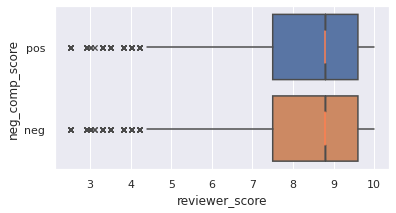

In [65]:
# распределение позитивных и негативных оценок в негативных отзывах
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(
    data=fe_data[mask_no_test], x="reviewer_score", y="neg_comp_score",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},
)

<AxesSubplot: xlabel='reviewer_score', ylabel='pos_comp_score'>

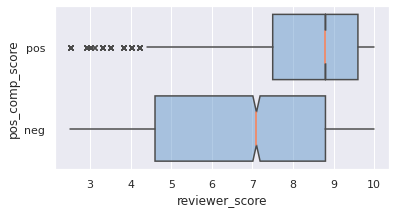

In [66]:
# распределение позитивных и негативных оценок в позитивных отзывах
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(
    data=fe_data[mask_no_test], x="reviewer_score", y="pos_comp_score",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)

### 2.5.5. Обработаю адрес

In [67]:
#fe_data = hotels_eda.copy()
fe_data['location'] = fe_data.hotel_address.str.split().str[-2:].apply(lambda x: '_'.join(x))
print(fe_data.location.unique())
fe_data.location.value_counts()

['United_Kingdom' 'Paris_France' 'Amsterdam_Netherlands' 'Milan_Italy'
 'Vienna_Austria' 'Barcelona_Spain']


United_Kingdom           262301
Barcelona_Spain           60149
Paris_France              59928
Amsterdam_Netherlands     57214
Vienna_Austria            38939
Milan_Italy               37207
Name: location, dtype: int64

<AxesSubplot: >

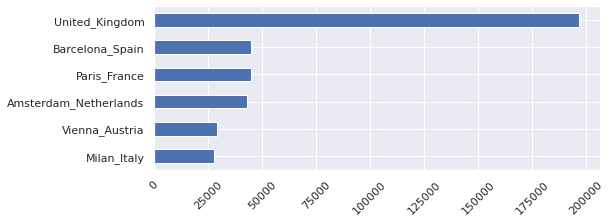

In [68]:
# посмотрим на количественное соотношение отзывов по городам
plt.rcParams['figure.figsize'] = (8,3)
plt.xticks(rotation=45)
fe_data[mask_no_test]['location'].value_counts(ascending=True).plot(kind='barh')

Теперь понятно почему примерно половина значений на всех распределниях выделяются в отдельную группу, это как раз отзывы из Великобритании. Судя по всему у нас представлены столицы, а население Лондона как мегаполиса значительно больше чем в европейских городах.

<AxesSubplot: xlabel='reviewer_score', ylabel='location'>

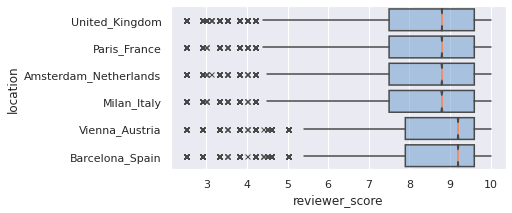

In [69]:
# распределение целевой переменной по городам
plt.rcParams['figure.figsize'] = (6,3)
sns.boxplot(
    data=fe_data[mask_no_test], x="reviewer_score", y="location",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)


<AxesSubplot: xlabel='reviewer_score', ylabel='location'>

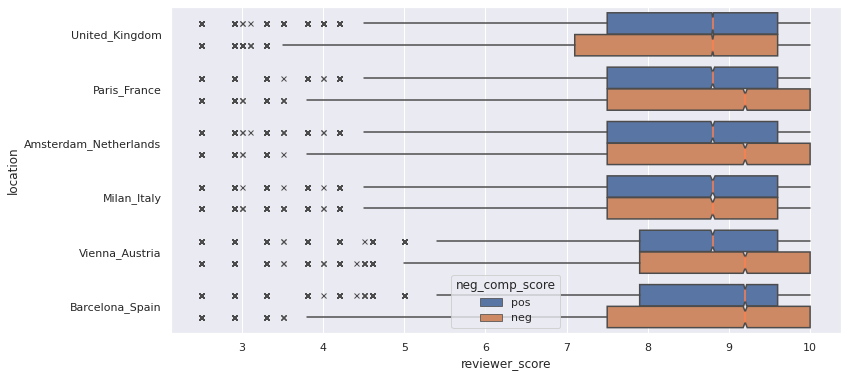

In [70]:
# распределение позитивных и негативных оценок в негативных отзывах по городам
plt.rcParams['figure.figsize'] = (12,6)
sns.boxplot(
    data=fe_data[mask_no_test], x="reviewer_score", y="location",
    hue = 'neg_comp_score',
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},
)

Как то странно, что в Париже, Амстердаме и Вене медианная оценка выше у негативных отзывов. Интересно, завышать оценку после негативного описания это культурные особенности? 

<AxesSubplot: xlabel='reviewer_score', ylabel='location'>

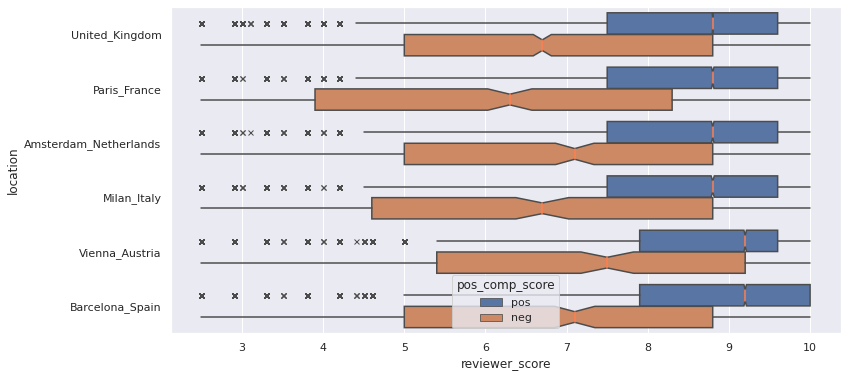

In [71]:
# распределение позитивных и негативных оценок в негативных отзывах по городам
plt.rcParams['figure.figsize'] = (12,6)
sns.boxplot(
    data=fe_data[mask_no_test], x="reviewer_score", y="location",
    hue = 'pos_comp_score',
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},
)

Тут все выглядит более логично, оценка выше у позитивного контекста и ниже у негативного

 Добавлю признак с населением

In [72]:
# население согласно Википедии, тыс.чел - population_dict
# добавим признак плотности населения, тыс. чел на км - pop_density_dict

fe_data['population'] = fe_data.apply(lambda row: population_dict[row['location']], axis=1)
fe_data['pop_density'] = fe_data.apply(lambda row: pop_density_dict[row['location']], axis=1)
fe_data.sample(3)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,distance,date_diff,is_weekend,wd,md,сount_tags,rare_tag,popular_tag,Leisure_trip,Submitted_from_a_mobile_device,Couple,Stayed_1_night,Stayed_2_nights,Solo_traveler,Stayed_3_nights,Business_trip,Group,Family_with_young_children,Stayed_4_nights,Double_Room,Standard_Double_Room,Superior_Double_Room,Family_with_older_children,neg_scores,pos_scores,neg_compound,pos_compound,neg_comp_score,pos_comp_score,location,population,pop_density
1488,265 Rotherhithe Street Southwark London SE16 5...,995,8.1,DoubleTree_by_Hilton_London_Docklands_Riverside,united_kingdom,The time you can get alcohol from the executi...,18,3826,The location was perfect the breakfast was su...,16,1,-1.0,"[Leisure trip, Couple, Executive King Room, St...",294,340,730,0,3,10,5,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.427, 'pos': 0.573, 'comp...",0.0000,0.9246,pos,pos,United_Kingdom,8962,5.7
82904,La Rambla 128 Ciutat Vella 08002 Barcelona Spain,226,8.1,Hotel_Serhs_Rivoli_Rambla,spain,Hotel was very noisy Constantly heard banging...,16,1957,Location on the Ramblas,5,1,6.7,"[Leisure trip, Solo traveler, Small Double Roo...",336,831,578,0,3,9,5,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'neg': 0.133, 'neu': 0.867, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",-0.2484,0.0000,neg,pos,Barcelona_Spain,1636,15.8
175908,18 Avenue De Suffren Entr e au 22 rue Jean Rey...,428,8.6,Pullman_Paris_Tour_Eiffel,canada,No Negative,0,2764,Awesome location Great staff,5,3,7.1,"[Leisure trip, Couple, Deluxe King Room Balcon...",71,4,730,0,2,5,5,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",-0.7096,0.8481,neg,pos,Paris_France,2148,20.8


### 2.5.6. Генерация статистических признаков

In [116]:
fe_data_256 = fe_data.copy()

count_hot_on_loc = fe_data_256['location'].value_counts()
count_hot = fe_data_256.hotel_name.value_counts()

median_score_on_loc = fe_data_256.groupby(['location'])['average_score'].median()
median_score_on_hot = fe_data_256.groupby(['hotel_name'])['average_score'].median()

min_score_on_loc = fe_data_256.groupby(['location'])['average_score'].min()
min_score_on_hot = fe_data_256.groupby(['hotel_name'])['average_score'].min()

max_score_on_loc = fe_data_256.groupby(['location'])['average_score'].max()
max_score_on_hot = fe_data_256.groupby(['hotel_name'])['average_score'].max()

median_neg_count_on_loc = fe_data_256.groupby(['location'])['review_total_negative_word_counts'].median()
median_neg_count_on_hot = fe_data_256.groupby(['hotel_name'])['review_total_negative_word_counts'].median()

min_neg_count_on_loc = fe_data_256.groupby(['location'])['review_total_negative_word_counts'].min()
min_neg_count_on_hot = fe_data_256.groupby(['hotel_name'])['review_total_negative_word_counts'].min()

max_neg_count_on_loc = fe_data_256.groupby(['location'])['review_total_negative_word_counts'].max()
max_neg_count_on_hot = fe_data_256.groupby(['hotel_name'])['review_total_negative_word_counts'].max()

median_pos_compound_on_loc = fe_data_256.groupby(['location'])['pos_compound'].median()
median_pos_compound_on_hot = fe_data_256.groupby(['hotel_name'])['pos_compound'].median()

min_pos_compound_on_loc = fe_data_256.groupby(['location'])['pos_compound'].min()
min_pos_compound_on_hot = fe_data_256.groupby(['hotel_name'])['pos_compound'].min()

max_pos_compound_on_loc = fe_data_256.groupby(['location'])['pos_compound'].max()
max_pos_compound_on_hot = fe_data_256.groupby(['hotel_name'])['pos_compound'].max()


fe_data_256['count_hot_on_loc'] = fe_data_256.location.apply(lambda x: count_hot_on_loc[x])
fe_data_256['count_hot'] = fe_data_256.hotel_name.apply(lambda x: count_hot[x])

fe_data_256['median_score_on_loc'] = fe_data_256.location.apply(lambda x: median_score_on_loc[x])
fe_data_256['median_score_on_hot'] = fe_data_256.hotel_name.apply(lambda x: median_score_on_hot[x])

fe_data_256['min_score_on_loc'] = fe_data_256.location.apply(lambda x: min_score_on_loc[x])
fe_data_256['min_score_on_hot'] = fe_data_256.hotel_name.apply(lambda x: min_score_on_hot[x])

fe_data_256['max_score_on_loc'] = fe_data_256.location.apply(lambda x: max_score_on_loc[x])
fe_data_256['max_score_on_hot'] = fe_data_256.hotel_name.apply(lambda x: max_score_on_hot[x])

fe_data_256['median_neg_count_on_loc'] = fe_data_256.location.apply(lambda x: median_neg_count_on_loc[x])
fe_data_256['median_neg_count_on_hot'] = fe_data_256.hotel_name.apply(lambda x: median_neg_count_on_hot[x])

fe_data_256['min_neg_count_on_loc'] = fe_data_256.location.apply(lambda x: min_neg_count_on_loc[x])
fe_data_256['min_neg_count_on_hot'] = fe_data_256.hotel_name.apply(lambda x: min_neg_count_on_hot[x])

fe_data_256['max_neg_count_on_loc'] = fe_data_256.location.apply(lambda x: max_neg_count_on_loc[x])
fe_data_256['max_neg_count_on_hot'] = fe_data_256.hotel_name.apply(lambda x: max_neg_count_on_hot[x])

fe_data_256['median_pos_compound_on_loc'] = fe_data_256.location.apply(lambda x: median_pos_compound_on_loc[x])
fe_data_256['median_pos_compound_on_hot'] = fe_data_256.hotel_name.apply(lambda x: median_pos_compound_on_hot[x])

fe_data_256['min_pos_compound_on_loc'] = fe_data_256.location.apply(lambda x: min_pos_compound_on_loc[x])
fe_data_256['min_pos_compound_on_hot'] = fe_data_256.hotel_name.apply(lambda x: min_pos_compound_on_hot[x])

fe_data_256['max_pos_compound_on_loc'] = fe_data_256.location.apply(lambda x: max_pos_compound_on_loc[x])
fe_data_256['max_pos_compound_on_hot'] = fe_data_256.hotel_name.apply(lambda x: max_pos_compound_on_hot[x])

fe_data_256.head(3)


,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,distance,date_diff,is_weekend,wd,md,сount_tags,rare_tag,popular_tag,Leisure_trip,Submitted_from_a_mobile_device,Couple,Stayed_1_night,Stayed_2_nights,Solo_traveler,Stayed_3_nights,Business_trip,Group,Family_with_young_children,Stayed_4_nights,Double_Room,Standard_Double_Room,Superior_Double_Room,Family_with_older_children,neg_scores,pos_scores,neg_compound,pos_compound,neg_comp_score,pos_comp_score,location,population,pop_density,count_hot_on_loc,count_hot,median_score_on_loc,median_score_on_hot,min_score_on_loc,min_score_on_hot,max_score_on_loc,max_score_on_hot,median_neg_count_on_loc,median_neg_count_on_hot,min_neg_count_on_loc,min_neg_count_on_hot,max_neg_count_on_loc,max_neg_count_on_hot,median_pos_compound_on_loc,median_pos_compound_on_hot,min_pos_compound_on_loc,min_pos_compound_on_hot,max_pos_compound_on_loc,max_pos_compound_on_hot
0,Stratton Street Mayfair Westminster Borough Lo...,581,8.4,The_May_Fair_Hotel,united_kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[Leisure trip, Couple, Studio Suite, Stayed 2 ...",531,344,729,0,4,2,5,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp...",0.0000,0.5859,pos,pos,United_Kingdom,8962,5.7,262301,800,8.4,8.4,6.4,8.4,9.6,8.4,10.0,10.0,0,0,403,390,0.6808,0.5859,-0.9806,-0.8625,0.9993,0.9967
1,130 134 Southampton Row Camden London WC1B 5AF...,299,8.3,Mercure_London_Bloomsbury_Hotel,united_kingdom,poor breakfast,3,1361,location,2,14,6.3,"[Business trip, Couple, Standard Double Room, ...",203,345,730,0,3,1,4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",-0.4767,0.0000,neg,pos,United_Kingdom,8962,5.7,262301,602,8.4,8.3,6.4,8.3,9.6,8.3,10.0,9.0,0,0,403,275,0.6808,0.7184,-0.9806,-0.8126,0.9993,0.9945
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,8.9,Legend_Saint_Germain_by_Elegancia,china,No kettle in room,6,406,No Positive,0,14,7.5,"[Leisure trip, Solo traveler, Modern Double Ro...",289,2,693,0,1,10,5,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",-0.2960,0.3400,neg,pos,Paris_France,2148,20.8,59928,78,8.5,8.9,6.8,8.9,9.8,8.9,7.0,4.0,0,0,392,149,0.7184,0.8568,-0.9538,0.0000,0.9988,0.9927


### 2.5.7. Генерация полиномиальных признаков

сгенерирую полиномиальные признаки на основе 2х самых значимых признаков review_total_negative_word_counts и pos_compound, предварительно нормализую счетчик негативных отзывов используя RobustScaler

In [118]:
fe_data_257 = fe_data.copy()

fe_data_257["index"] = fe_data_257.index

fe_data_257 = fe_data_257.reset_index()

fe_data_257['rev_total_neg_word_counts_log'] = np.log(fe_data_257[['review_total_negative_word_counts']] +1)

# Матрица признаков
X_data = fe_data_257[['rev_total_neg_word_counts_log', 'pos_compound']]

# Создание экземпляра класса PolynomialFeatures
polynom_data = PolynomialFeatures(degree=2, interaction_only=False)

# Создать новую матрицу признаков
poly_features = pd.DataFrame(polynom_data.fit_transform(X_data), 
                             columns=polynom_data.get_feature_names(X_data.columns))

# удалю повторяющиеся столбцы
poly_features.drop(['1', 'rev_total_neg_word_counts_log', 'pos_compound'], axis=1, inplace=True)
# объединим фрейм сгенерированным признаков с нашим датасетом
fe_data_257 = pd.concat([fe_data_257, poly_features], axis=1)

fe_data_257.set_index('index',inplace=True)

fe_data_257.head(3)



,level_0,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,distance,date_diff,is_weekend,wd,md,сount_tags,rare_tag,popular_tag,Leisure_trip,Submitted_from_a_mobile_device,Couple,Stayed_1_night,Stayed_2_nights,Solo_traveler,Stayed_3_nights,Business_trip,Group,Family_with_young_children,Stayed_4_nights,Double_Room,Standard_Double_Room,Superior_Double_Room,Family_with_older_children,neg_scores,pos_scores,neg_compound,pos_compound,neg_comp_score,pos_comp_score,location,population,pop_density,rev_total_neg_word_counts_log,rev_total_neg_word_counts_log^2,rev_total_neg_word_counts_log pos_compound,pos_compound^2
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,Stratton Street Mayfair Westminster Borough Lo...,581,8.4,The_May_Fair_Hotel,united_kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[Leisure trip, Couple, Studio Suite, Stayed 2 ...",531,344,729,0,4,2,5,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp...",0.0000,0.5859,pos,pos,United_Kingdom,8962,5.7,1.386294,1.921812,0.812230,0.343279
1,1,130 134 Southampton Row Camden London WC1B 5AF...,299,8.3,Mercure_London_Bloomsbury_Hotel,united_kingdom,poor breakfast,3,1361,location,2,14,6.3,"[Business trip, Couple, Standard Double Room, ...",203,345,730,0,3,1,4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",-0.4767,0.0000,neg,pos,United_Kingdom,8962,5.7,1.386294,1.921812,0.000000,0.000000
2,2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,8.9,Legend_Saint_Germain_by_Elegancia,china,No kettle in room,6,406,No Positive,0,14,7.5,"[Leisure trip, Solo traveler, Modern Double Ro...",289,2,693,0,1,10,5,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",-0.2960,0.3400,neg,pos,Paris_France,2148,20.8,1.945910,3.786566,0.661609,0.115600


In [108]:
fe_data_257['rev_total_neg_word_counts_log pos_compound'].describe()

count    515738.000000
mean          1.211732
std           1.238191
min          -5.696457
25%           0.000000
50%           1.046318
75%           2.126474
max           5.929412
Name: rev_total_neg_word_counts_log pos_compound, dtype: float64

# 3. Preprocessing

In [40]:
# конечная функция полной предобработки датасета для обучения
def preproc_data(df_input: pd.DataFrame) -> pd.DataFrame:
    
    df_output = df_input.copy()
  
    # сохраним исходные индексы в отдельный столбец
    df_output["index"] = df_output.index
    
    # Обработаю координаты
    # заполню пропуски
    df_output['lat'] = df_output['lat'].fillna(df_output['hotel_address'].map(lat_dict))
    df_output['lng'] = df_output['lng'].fillna(df_output['hotel_address'].map(lng_dict))
    
    # Очистим от лишних пробелов и заменим пропуски на _ в названиях отелей и национальности ревьювера
    df_output.reviewer_nationality = df_output.reviewer_nationality.apply(lambda x: x.strip())
    df_output.reviewer_nationality = df_output.reviewer_nationality.str.lower().str.replace(' ', '_', 
                                                                                              regex=True)
    df_output.hotel_name = df_output.hotel_name.str.replace(' ', '_', regex=True)
    
    # определю по координатам расстояние до Парижа
    # координаты Парижа
    lon1_p = 2.3488000
    lat1_p = 48.8534100
    df_output['distance_to_Paris'] = df_output.apply(lambda row: haversine(lon1 = lon1_p, lat1 = lat1_p, 
                                                                           lon2 = row['lng'], 
                                                                           lat2 = row['lat']), axis=1)
    
    # определю по координатам расстояние до Амстердама
    # координаты Амстердама
    lon1_a = 4.8896900
    lat1_a = 52.3740300
    df_output['distance_to_Amsterdam'] = df_output.apply(lambda row: haversine(lon1 = lon1_a, lat1 = lat1_a, 
                                                                               lon2 = row['lng'], 
                                                                               lat2 = row['lat']), axis=1)
    
    # определю по координатам расстояние до Вены
    # координаты Вены
    lon1_v = 16.3720800
    lat1_v = 48.2084900
    df_output['distance_to_Vena'] = df_output.apply(lambda row: haversine(lon1 = lon1_v, lat1 = lat1_v, 
                                                                          lon2 = row['lng'], 
                                                                          lat2 = row['lat']), axis=1)
    
    # определю по координатам расстояние до Милана
    # координаты Милана
    lon1_m = 9.1895100
    lat1_m = 45.4642700
    df_output['distance_to_Milan'] = df_output.apply(lambda row: haversine(lon1 = lon1_p, lat1 = lat1_p, 
                                                                           lon2 = row['lng'], 
                                                                           lat2 = row['lat']), axis=1)
    
    # определю по координатам расстояние до Лондона
    # координаты Лондона
    lon1_l = -0.1257400
    lat1_l = 51.5085300
    df_output['distance_to_London'] = df_output.apply(lambda row: haversine(lon1 = lon1_l, lat1 = lat1_l, 
                                                                            lon2 = row['lng'], 
                                                                            lat2 = row['lat']), axis=1)
    
    # определю по координатам расстояние до Барселоны
    # координаты Барселоны 
    lon1_b = 2.1589900
    lat1_b = 41.3887900
    df_output['distance_to_Barselona'] = df_output.apply(lambda row: haversine(lon1 = lon1_b, lat1 = lat1_b, 
                                                                               lon2 = row['lng'], 
                                                                               lat2 = row['lat']), axis=1)
    
    
    # по сути признак с расстоянием описывает наши координаты, можем исходные широты/долготы удалить
    df_output.drop(['lat', 'lng'], axis=1, inplace=True)
    
    # Обработка тегов
    # переведем признак с тэгами в список
    df_output['tags_listed'] = df_output.tags.str.findall(r"' (\b.*?\b) '")
    # создам признак с количеством тегов
    df_output['сount_tags'] = df_output.tags_listed.apply(lambda x: len(x))

    # обработаю теги с использованием библиотеки Counter
    temp_list = df_output['tags_listed'].tolist()
    temp_Counter = Counter(list_unrar(temp_list))
    
    # список самых популярных тегов
    list_of_most_popular_tag = [x[0] for x in temp_Counter.most_common(15)]
    # список популярных тегов
    list_of_popular_tag = [x[0] for x in temp_Counter.most_common()[15:600]]
    # список редких тегов
    list_of_rare_tag = [x[0] for x in temp_Counter.most_common()[600:]]
    
    # создам признаки на основе популярности тегов
    df_output['rare_tag'] = df_output.tags_listed.apply(lambda x: 1 if len(set(x) & set(list_of_rare_tag))>0  
                                                 else 0).astype('float64')
    df_output['popular_tag'] = df_output.tags_listed.apply(lambda x: 1 if len(set(x) & set(list_of_popular_tag))>0  
                                                    else 0).astype('float64')

    # а самые популярные 15 тегов выведем в отдельные категории
    for tag in list_of_most_popular_tag:
        df_output[tag] = df_output.tags_listed.apply(lambda x: 1 if tag in x else 0 ).astype('float64')
            
    # удвлю более не нужные столбцы с тегами
    df_output.drop(['tags', 'tags_listed'], axis=1, inplace=True)
    
    
    # Обработка временных признаков
    # преобразуем тип признака с датой
    df_output.review_date =  pd.to_datetime(df_output.review_date)
    
    # создам признак с периодом между самым новым и самым старым отзывом по адресу отеля
    grp_name = df_output.groupby(['hotel_address']).review_date.max() - df_output.groupby(['hotel_address']).review_date.min()
    df_output['date_diff'] = df_output.hotel_address.apply(lambda x: grp_name[x]).dt.days
    
    # преобразуем признак days_since_review в числовой
    df_output['days_since_review'] = pd.to_numeric(df_output['days_since_review'].str.split().str[0])
    
    # выделю из даты отзыва является ли выходным днем
    df_output['is_weekend'] = df_output.review_date.dt.weekday.apply(lambda x: 1 if x > 4 else 0)
    # выделю из даты отзыва день недели
    df_output['wd'] = df_output.review_date.dt.weekday
    # выделю из даты отзыва число месяца
    df_output['md'] = df_output.review_date.dt.month
    # удалю дату отзыва
    df_output.drop('review_date', axis=1, inplace=True)
    
    # Обработка адреса
    # Вытащим последние 2 слова адреса с названием города и страны
    df_output['location'] = df_output.hotel_address.str.split().str[-2:].apply(lambda x: '_'.join(x))
    
    # создам признаки с населением города и плотностью населения в нем
    df_output['population'] = df_output.apply(lambda row: population_dict[row['location']], axis=1)
    df_output['pop_density'] = df_output.apply(lambda row: pop_density_dict[row['location']], axis=1)
    
    # удалю адрес
    df_output.drop('hotel_address', axis=1, inplace=True)
    
    #  Обработка текстов отзывов
    # Инициализирую анализатор текста
    sid = SentimentIntensityAnalyzer()
    
    # Анализ текстов позитивных и негативных отзывов
    df_output['neg_scores'] = df_output['negative_review'].apply(lambda review: sid.polarity_scores(review))
    df_output['pos_scores'] = df_output['positive_review'].apply(lambda review: sid.polarity_scores(review))
    
    # Суммарна числовая метрика "позитивности" и "негативности" текста
    # Отзыв более позитивный если значение > 0 и более негативный если < 0
    df_output['neg_compound']  = df_output['neg_scores'].apply(lambda score_dict: score_dict['compound'])
    df_output['pos_compound']  = df_output['pos_scores'].apply(lambda score_dict: score_dict['compound'])

    df_output['is_pos_neg_review'] = df_output['neg_compound'].apply(lambda c: 1 if c >=0 else 0)
    df_output['is_pos_pos_rev'] = df_output['pos_compound'].apply(lambda c: 1 if c >=0 else 0)

    # удалю тексты отзывов и их метрики после анализа
    df_output.drop(['negative_review', 'positive_review', 'neg_scores', 'pos_scores'], axis=1, inplace=True)
    
    # самые популярные 10 национальностей выведу в отдельные признаки
    top_10_nationalities = ['united_kingdom', 'united_states_of_america', 'australia', 'ireland',
                       'united_arab_emirates', 'saudi_arabia', 'netherlands', 'switzerland',
                       'germany', 'canada']
    for nat in top_10_nationalities:
        df_output[nat] = df_output.reviewer_nationality.apply(lambda x: 1 if nat in x else 0 ).astype('float64')
            
        
    # генерация статистических признаков по городу и по отелю
    count_hot_on_loc = df_output['location'].value_counts()
    count_hot = df_output.hotel_name.value_counts()

    median_num_on_loc = df_output.groupby(['location'])['total_number_of_reviews'].median()
    min_num_on_loc = df_output.groupby(['location'])['total_number_of_reviews'].min()
    max_num_on_loc = df_output.groupby(['location'])['total_number_of_reviews'].max()

    median_neg_count_on_loc = df_output.groupby(['location'])['review_total_negative_word_counts'].median()
    median_neg_count_on_hot = df_output.groupby(['hotel_name'])['review_total_negative_word_counts'].median()

    min_neg_count_on_loc = df_output.groupby(['location'])['review_total_negative_word_counts'].min()
    min_neg_count_on_hot = df_output.groupby(['hotel_name'])['review_total_negative_word_counts'].min()

    max_neg_count_on_loc = df_output.groupby(['location'])['review_total_negative_word_counts'].max()
    max_neg_count_on_hot = df_output.groupby(['hotel_name'])['review_total_negative_word_counts'].max()

    median_pos_compound_on_loc = df_output.groupby(['location'])['pos_compound'].median()
    median_pos_compound_on_hot = df_output.groupby(['hotel_name'])['pos_compound'].median()

    min_pos_compound_on_loc = df_output.groupby(['location'])['pos_compound'].min()
    min_pos_compound_on_hot = df_output.groupby(['hotel_name'])['pos_compound'].min()

    max_pos_compound_on_loc = df_output.groupby(['location'])['pos_compound'].max()
    max_pos_compound_on_hot = df_output.groupby(['hotel_name'])['pos_compound'].max()


    df_output['count_hot_on_loc'] = df_output.location.apply(lambda x: count_hot_on_loc[x])
    df_output['count_hot'] = df_output.hotel_name.apply(lambda x: count_hot[x])

    df_output['median_num_on_loc'] = df_output.location.apply(lambda x: median_num_on_loc[x])
    df_output['min_num_on_loc'] = df_output.location.apply(lambda x: min_num_on_loc[x])
    df_output['max_num_on_loc'] = df_output.location.apply(lambda x: max_num_on_loc[x])

    df_output['median_neg_count_on_loc'] = df_output.location.apply(lambda x: median_neg_count_on_loc[x])
    df_output['median_neg_count_on_hot'] = df_output.hotel_name.apply(lambda x: median_neg_count_on_hot[x])

    df_output['max_neg_count_on_loc'] = df_output.location.apply(lambda x: max_neg_count_on_loc[x])
    df_output['max_neg_count_on_hot'] = df_output.hotel_name.apply(lambda x: max_neg_count_on_hot[x])

    df_output['median_pos_compound_on_loc'] = df_output.location.apply(lambda x: median_pos_compound_on_loc[x])
    df_output['median_pos_compound_on_hot'] = df_output.hotel_name.apply(lambda x: median_pos_compound_on_hot[x])

    df_output['min_pos_compound_on_loc'] = df_output.location.apply(lambda x: min_pos_compound_on_loc[x])
    df_output['min_pos_compound_on_hot'] = df_output.hotel_name.apply(lambda x: min_pos_compound_on_hot[x])

    df_output['max_pos_compound_on_loc'] = df_output.location.apply(lambda x: max_pos_compound_on_loc[x])
    df_output['max_pos_compound_on_hot'] = df_output.hotel_name.apply(lambda x: max_pos_compound_on_hot[x])
    
    # генерация полиномиальных признаков
    df_output = df_output.reset_index()

    # Матрица признаков
    X_data = df_output[['review_total_negative_word_counts', 'review_total_positive_word_counts']]

    # Создание экземпляра класса PolynomialFeatures
    polynom_data = PolynomialFeatures(degree=2, interaction_only=False)

    # Создать новую матрицу признаков
    poly_features = pd.DataFrame(polynom_data.fit_transform(X_data), 
                                 columns=polynom_data.get_feature_names(X_data.columns))

    # удалю повторяющиеся столбцы
    poly_features.drop(['1', 'review_total_negative_word_counts', 'review_total_positive_word_counts'], 
                       axis=1, inplace=True)
    
    # объединим фрейм сгенерированным признаков с нашим датасетом
    df_output = pd.concat([df_output, poly_features], axis=1)

    # вернем исходные индексы
    df_output.set_index('index',inplace=True)
    
    # Cоздам еще несколько признаков
    
    # отношение разницы количества дней между самым старым и самым свежим отзывами и количества дней с отзыва 
    # к количеству отзывов у отеля
    df_output['days_by_count'] = (df_output.date_diff - df_output.days_since_review)/ df_output.population
    
    # отношение произведения количества отзывов у отеля и количества отелей в городе к населению города
    df_output['count_by_pop'] = df_output.count_hot * df_output.count_hot_on_loc*0.001 / df_output.population
    
    # отношение суммы количества позитивных и негативных слов к среднему баллу отеля за прошлый год 
    df_output['neg_plus_pos_by_total'] = (df_output.review_total_negative_word_counts + 
                                          df_output.review_total_positive_word_counts)/df_output.average_score
    
    # отношение количества добавочных оценок к общему количеству отзывов
    df_output['add_num_by_total'] = df_output.additional_number_of_scoring/df_output.total_number_of_reviews
    
    df_output.drop(['level_0'], axis=1, inplace=True)
    
    # уберу пробелы в названиях колонок
    df_output.columns = [column.replace(' ','_') for column in df_output.columns]   

        
    return df_output


In [41]:
%%time

# Первым делом объединяем выборки
combined_data = join_df(df_train, df_test)

# Затем используем нашу функцию предобработки
combined_data = preproc_data(combined_data)

combined_data.describe()

CPU times: user 4min 8s, sys: 1.33 s, total: 4min 10s
Wall time: 4min 9s


,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,distance_to_Paris,distance_to_Amsterdam,distance_to_Vena,distance_to_Milan,distance_to_London,distance_to_Barselona,сount_tags,rare_tag,popular_tag,Leisure_trip,Submitted_from_a_mobile_device,Couple,Stayed_1_night,Stayed_2_nights,Solo_traveler,Stayed_3_nights,Business_trip,Group,Family_with_young_children,Stayed_4_nights,Double_Room,Standard_Double_Room,Superior_Double_Room,Family_with_older_children,date_diff,is_weekend,wd,md,population,pop_density,neg_compound,pos_compound,is_pos_neg_review,is_pos_pos_rev,united_kingdom,united_states_of_america,australia,ireland,united_arab_emirates,saudi_arabia,netherlands,switzerland,germany,canada,count_hot_on_loc,count_hot,median_num_on_loc,min_num_on_loc,max_num_on_loc,median_neg_count_on_loc,median_neg_count_on_hot,max_neg_count_on_loc,max_neg_count_on_hot,median_pos_compound_on_loc,median_pos_compound_on_hot,min_pos_compound_on_loc,min_pos_compound_on_hot,max_pos_compound_on_loc,max_pos_compound_on_hot,review_total_negative_word_counts^2,review_total_negative_word_counts_review_total_positive_word_counts,review_total_positive_word_counts^2,days_by_count,count_by_pop,neg_plus_pos_by_total,add_num_by_total
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.00000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.047671,354.441932,444.054477,507.122801,1055.420803,444.054477,376.427929,967.799883,4.569359,0.049930,0.778389,0.810059,0.596504,0.489190,0.375472,0.25970,0.210465,0.185794,0.160816,0.126793,0.118306,0.092716,0.068265,0.062528,0.060870,0.051090,707.500299,0.263339,2.721601,6.486660,5337.970497,8.579159,-0.209151,0.593533,0.465647,0.985962,0.475524,0.068711,0.042048,0.028749,0.019845,0.017356,0.017009,0.016826,0.015397,0.015306,159354.420950,909.535586,2188.248380,59.602847,10323.103182,9.239488,9.279151,400.392317,278.389275,0.703422,0.687215,-0.977476,-0.669211,0.999032,0.992857,1225.254934,407.001394,791.424039,0.141867,30.168683,4.352549,0.179050
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,4.308626,208.928124,272.075164,352.221517,354.323196,272.075164,467.576897,386.210942,0.520187,0.217801,0.415331,0.392255,0.490599,0.499884,0.484245,0.43847,0.407640,0.388941,0.367362,0.332741,0.322971,0.290034,0.252201,0.242112,0.239092,0.220181,77.503307,0.440445,2.084341,3.351779,3700.911734,5.528207,0.453386,0.342460,0.498819,0.117648,0.499401,0.252963,0.200700,0.167101,0.139469,0.130593,0.129303,0.128621,0.123127,0.122768,104952.832906,890.286061,573.880501,25.855637,3074.141335,1.083797,3.243617,7.320829,92.681978,0.026484,0.104680,0.008666,0.261643,0.000339,0.005828,5977.786431,1567.043524,3404.139338,0.165287,29.491502,4.700746,0.075779
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00

In [42]:
combined_data.head(2)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,distance_to_Paris,distance_to_Amsterdam,distance_to_Vena,distance_to_Milan,distance_to_London,distance_to_Barselona,сount_tags,rare_tag,popular_tag,Leisure_trip,Submitted_from_a_mobile_device,Couple,Stayed_1_night,Stayed_2_nights,Solo_traveler,Stayed_3_nights,Business_trip,Group,Family_with_young_children,Stayed_4_nights,Double_Room,Standard_Double_Room,Superior_Double_Room,Family_with_older_children,date_diff,is_weekend,wd,md,location,population,pop_density,neg_compound,pos_compound,is_pos_neg_review,is_pos_pos_rev,united_kingdom,united_states_of_america,australia,ireland,united_arab_emirates,saudi_arabia,netherlands,switzerland,germany,canada,count_hot_on_loc,count_hot,median_num_on_loc,min_num_on_loc,max_num_on_loc,median_neg_count_on_loc,median_neg_count_on_hot,max_neg_count_on_loc,max_neg_count_on_hot,median_pos_compound_on_loc,median_pos_compound_on_hot,min_pos_compound_on_loc,min_pos_compound_on_hot,max_pos_compound_on_loc,max_pos_compound_on_hot,review_total_negative_word_counts^2,review_total_negative_word_counts_review_total_positive_word_counts,review_total_positive_word_counts^2,days_by_count,count_by_pop,neg_plus_pos_by_total,add_num_by_total
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,581,8.4,The_May_Fair_Hotel,united_kingdom,3,1994,4,7,10.0,531,344,358,1236,344,1,1139,5,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,729,0,4,2,United_Kingdom,8962,5.7,0.0000,0.5859,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262301,800,2298.0,45,12158,10.0,10.0,403,390,0.6808,0.5859,-0.9806,-0.8625,0.9993,0.9967,9.0,12.0,16.0,0.022093,23.414506,0.833333,0.291374
1,299,8.3,Mercure_London_Bloomsbury_Hotel,united_kingdom,3,1361,2,14,6.3,203,345,356,1235,345,1,1140,4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,730,0,3,1,United_Kingdom,8962,5.7,-0.4767,0.0000,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262301,602,2298.0,45,12158,10.0,9.0,403,275,0.6808,0.7184,-0.9806,-0.8126,0.9993,0.9945,9.0,6.0,4.0,0.058804,17.619416,0.602410,0.219691


In [44]:
%%time

# Закодируем оставшиеся нечисловые признаки
preproc_df = code_data(combined_data)

'''# столбцы с числовыми данными для логарифмирования
num_cols = ['additional_number_of_scoring', 
            'total_number_of_reviews', 'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'distance', 
           'date_diff', 'population', 'count_hot_on_loc', 'count_hot', 'max_neg_count_on_loc',
           'max_neg_count_on_hot']

# логарифмируем столбцы с большими числами, добавим сразу +1 чтоб нулевые значения не выдвали ошибку
for i  in list(preproc_data.columns):
    if i in num_cols:
        preproc_data[i] = np.log(preproc_data[i]+1)
        '''

# стандартизирую все значения

for i in list(preproc_df.columns):
    if i not in ['reviewer_score']:
        preproc_df[i] = RobustScaler_column(i)
        
preproc_df.describe()

CPU times: user 12.4 s, sys: 6.6 s, total: 19 s
Wall time: 19 s


,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,distance_to_Paris,distance_to_Amsterdam,distance_to_Vena,distance_to_Milan,distance_to_London,distance_to_Barselona,сount_tags,rare_tag,popular_tag,Leisure_trip,Submitted_from_a_mobile_device,Couple,Stayed_1_night,Stayed_2_nights,Solo_traveler,Stayed_3_nights,Business_trip,Group,Family_with_young_children,Stayed_4_nights,Double_Room,Standard_Double_Room,Superior_Double_Room,Family_with_older_children,date_diff,is_weekend,wd,md,population,pop_density,neg_compound,pos_compound,is_pos_neg_review,is_pos_pos_rev,united_kingdom,united_states_of_america,australia,ireland,united_arab_emirates,saudi_arabia,netherlands,switzerland,germany,canada,count_hot_on_loc,count_hot,median_num_on_loc,min_num_on_loc,max_num_on_loc,median_neg_count_on_loc,median_neg_count_on_hot,max_neg_count_on_loc,max_neg_count_on_hot,median_pos_compound_on_loc,median_pos_compound_on_hot,min_pos_compound_on_loc,min_pos_compound_on_hot,max_pos_compound_on_loc,max_pos_compound_on_hot,review_total_negative_word_counts^2,review_total_negative_word_counts_review_total_positive_word_counts,review_total_positive_word_counts^2,days_by_count,count_by_pop,neg_plus_pos_by_total,add_num_by_total,location_United_Kingdom,location_Paris_France,location_Amsterdam_Netherlands,location_Milan_Italy,location_Vienna_Austria,location_Barcelona_Spain,hotel_name_0,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.00000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,0.319922,-0.003590,0.454260,0.248672,0.398615,0.595143,6.047671,0.004096,0.332388,0.310239,-0.595264,0.332388,0.382000,-0.552598,-0.430641,0.049930,-0.221611,-0.189941,-0.403496,0.489190,0.375472,0.25970,0.210465,0.185794,0.160816,0.126793,0.118306,0.092716,0.068265,0.062528,0.060870,0.051090,-5.374925,0.263339,0.180400,-0.102668,-0.494681,1.515347,-0.044040,-0.216530,0.465647,-0.014038,0.475524,0.068711,0.042048,0.028749,0.019845,0.017356,0.017009,0.016826,0.015397,0.015306,-0.501965,0.309253,-5.776401,0.663766,-0.341949,-0.380256,0.069788,-2.607683,-0.058962,0.490710,-0.154782,1.562244,0.248583,-0.536403,-0.296743,2.179533,1.180277,1.460619,0.414682,0.312552,0.357047,0.020180,-0.491406,0.116199,0.110936,0.072143,0.075502,0.116627,0.095136,0

In [45]:
preproc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 99 columns):
 #   Column                                                               Non-Null Count   Dtype  
---  ------                                                               --------------   -----  
 0   additional_number_of_scoring                                         515738 non-null  float64
 1   average_score                                                        515738 non-null  float64
 2   review_total_negative_word_counts                                    515738 non-null  float64
 3   total_number_of_reviews                                              515738 non-null  float64
 4   review_total_positive_word_counts                                    515738 non-null  float64
 5   total_number_of_reviews_reviewer_has_given                           515738 non-null  float64
 6   reviewer_score                                                       515738 non-null  float6

# 4. Modelling

## 4.1. Splitting

In [46]:
train_data, test_data = split_df(preproc_df)
# Проверки
print('train_data:', train_data.shape)
print('test_data:', test_data.shape)
print('Empty values in train:', train_data.isna().any().sum())
print('Empty values in test:', test_data.isna().any().sum())

train_data: (386803, 99)
test_data: (128935, 98)
Empty values in train: 0
Empty values in test: 0


In [47]:
y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [48]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [49]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 98), (386803, 99), (386803, 98), (309442, 98), (77361, 98))

## 4.2. Training and predicting

In [50]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [51]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [52]:
%%time

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


CPU times: user 29min 44s, sys: 1.11 s, total: 29min 45s
Wall time: 4min 4s


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


In [53]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.125726508708949


## 4.3. Features evaluating

<AxesSubplot: >

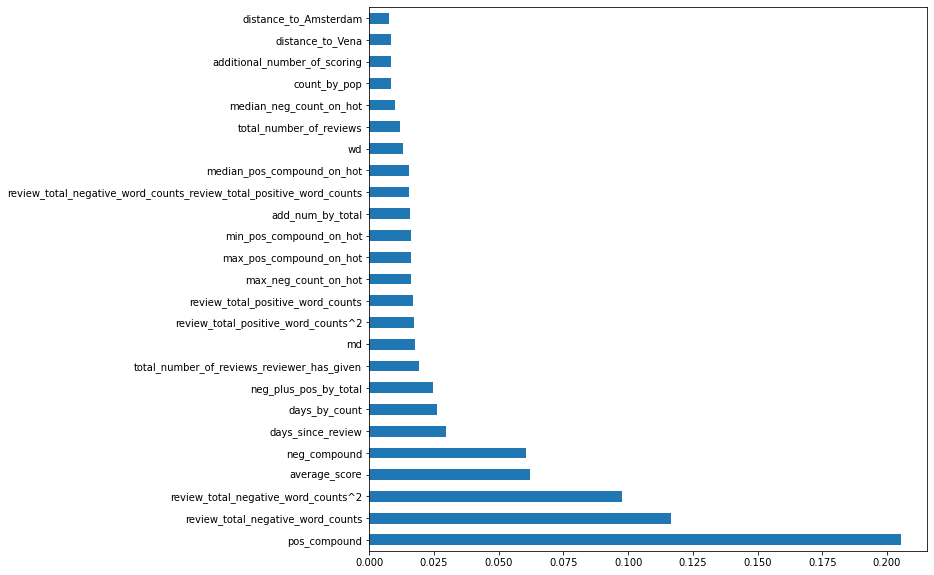

In [54]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

## 4.4. Блок подбора оптимальных параметров для модели

In [33]:
# # блок тестирования оптимального набора
list_ofAllColumnsSortImportant = list(feat_importances.nlargest(len(train_data.columns)-1).index)
MAPE = 0.1255732213883172
min_MAPE = round(MAPE,3)
print(f"min_MAPE = {min_MAPE}")
remove_list = []
log = []
delta =0.002

for i in range(0,len(list_ofAllColumnsSortImportant),1):
    col = list_ofAllColumnsSortImportant[i]
    print(f"{i}.{col}")
    ###

    y = train_data.reviewer_score.values            # наш таргет
    X = train_data.drop(['reviewer_score']+[col], axis=1)

    # Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
    # выделим 20% данных на валидацию (параметр test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
    
    model_ = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
    model_.fit(X_train, y_train)

    y_pred = model_.predict(X_test)
    
    temp_MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred)
     ###
    print(temp_MAPE)
    log.append([col, temp_MAPE])
    if round(temp_MAPE,3) <= min_MAPE-delta:
        remove_list.append(col)
        print(f"удаляем:= {col}")
    else:
        print(f"не удаляем:= {col}")
print(f"i={i}")
print(f"remove_list: {remove_list}")
print(f"log_list: {log}")

min_MAPE = 0.126
0.pos_compound


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


0.1257604805828392
не удаляем:= pos_compound
1.rev_total_neg_word_counts_log^2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.1256842502697656
не удаляем:= rev_total_neg_word_counts_log^2
2.review_total_negative_word_counts


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.12565778931215338
не удаляем:= review_total_negative_word_counts
3.rev_total_neg_word_counts_log


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


0.1256842746493937
не удаляем:= rev_total_neg_word_counts_log
4.neg_compound


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12757861773506382
не удаляем:= neg_compound
5.review_total_positive_word_counts


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12762983614705253
не удаляем:= review_total_positive_word_counts
6.days_since_review


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


0.12558632620589144
не удаляем:= days_since_review
7.neg_plus_pos_by_total


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


0.12573712454664474
не удаляем:= neg_plus_pos_by_total
8.days_by_count


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


0.12566618464848048
не удаляем:= days_by_count
9.pos_compound^2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.1257104524995182
не удаляем:= pos_compound^2
10.rev_total_neg_word_counts_log_pos_compound


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12568378095521382
не удаляем:= rev_total_neg_word_counts_log_pos_compound
11.min_score_on_hot


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12569668931224776
не удаляем:= min_score_on_hot
12.md


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12570678630141893
не удаляем:= md
13.max_neg_count_on_hot


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12560069064786505
не удаляем:= max_neg_count_on_hot
14.max_pos_compound_on_hot


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.12559005020580907
не удаляем:= max_pos_compound_on_hot
15.min_pos_compound_on_hot


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.12568906928310755
не удаляем:= min_pos_compound_on_hot
16.median_score_on_hot


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.12571058863846757
не удаляем:= median_score_on_hot
17.add_num_by_total


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


0.1255859212587592
не удаляем:= add_num_by_total
18.average_score


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


KeyboardInterrupt: 

log_list: [['review_total_negative_word_counts', 0.13495259505079762], ['pos_compound', 0.12952627484836082], ['average_score', 0.12987589897760388], ['neg_compound', 0.127566655401004], ['days_since_review', 0.12573100954012087], ['review_total_positive_word_counts', 0.1279606257471746], ['total_number_of_reviews', 0.12549434452067787], ['additional_number_of_scoring', 0.1255863894675009], ['total_number_of_reviews_reviewer_has_given', 0.12571736534854136], ['md', 0.1256357962640743], ['distance', 0.12561208779415942], ['wd', 0.1255633368084976], ['date_diff', 0.12559528947595988], ['pop_density', 0.12561642846770207], ['сount_tags', 0.12564090837436895], ['Couple', 0.12561497454706227], ['Stayed_1_night', 0.1256219630133779], ['population', 0.1255785194789783], ['Stayed_2_nights', 0.125635317528632], ['reviewer_nationality_5', 0.12556103258009194], ['hotel_name_4', 0.12560101281380645], ['hotel_name_5', 0.1255637005736949], ['hotel_name_7', 0.1255791240148922], ['hotel_name_6', 0.1255086981289665], ['hotel_name_10', 0.12560114451817134], ['hotel_name_8', 0.12562495716133162], ['reviewer_nationality_4', 0.1256951048735267], ['reviewer_nationality_6', 0.12563742421671298], ['hotel_name_3', 0.12556493101388116], ['hotel_name_9', 0.12561826273208787], ['reviewer_nationality_7', 0.125527461457266], ['reviewer_nationality_3', 0.12561802690570922], ['Solo_traveler', 0.12564531870390422], ['hotel_name_2', 0.1255779771621971], ['reviewer_nationality_2', 0.1256134468706838], ['Stayed_3_nights', 0.12555175035842972], ['Group', 0.12561613470414393], ['Family_with_young_children', 0.12560210185774792], ['Leisure_trip', 0.12564468303255935], ['Submitted_from_a_mobile_device', 0.12563019923986204], ['hotel_name_1', 0.12558963030740292], ['Business_trip', 0.1255853169561531], ['popular_tag', 0.12559157462660642], ['Stayed_4_nights', 0.12562771747849175], ['reviewer_nationality_1', 0.12560059661648237], ['Standard_Double_Room', 0.12565158932629505], ['Superior_Double_Room', 0.1257148288364868], ['Family_with_older_children', 0.1255863450287276], ['Double_Room', 0.12555556442937715], ['is_weekend', 0.12562185457822045], ['rare_tag', 0.12557500321659804], ['hotel_name_0', 0.12563714282418037], ['location_Milan_Italy', 0.125565176587838], ['is_pos_neg_review', 0.12558026334213696], ['location_Barcelona_Spain', 0.1256009084262588], ['location_United_Kingdom', 0.12557767201815628], ['location_Amsterdam_Netherlands', 0.1255983982505732], ['is_pos_pos_rev', 0.12558071349255928], ['location_Paris_France', 0.1255889476061933], ['location_Vienna_Austria', 0.12562304360047133], ['reviewer_nationality_0', 0.12558591144853862], ['Intercontinental_London_The_O2', 0.12561741168916704], ['germany', 0.12561741168916704], ['united_kingdom', 0.12561741168916707], ['united_states_of_america', 0.12561741168916707], ['australia', 0.12561741168916704], ['ireland', 0.12561741168916704], ['saudi_arabia', 0.12561741168916707], ['netherlands', 0.12561741168916707], ['switzerland', 0.12561741168916704], ['Britannia_International_Hotel_Canary_Wharf', 0.12561741168916707], ['canada', 0.12561741168916707], ['Strand_Palace_Hotel', 0.12561741168916704], ['Park_Plaza_Westminster_Bridge_London', 0.12561741168916707], ['Copthorne_Tara_Hotel_London_Kensington', 0.12561741168916704], ['DoubleTree_by_Hilton_Hotel_London_Tower_of_London', 0.12561741168916704], ['Grand_Royale_London_Hyde_Park', 0.12561741168916707], ['Holiday_Inn_London_Kensington', 0.12561741168916704], ['Hilton_London_Metropole', 0.12561741168916704], ['Millennium_Gloucester_Hotel_London', 0.12561741168916704], ['united_arab_emirates', 0.12561741168916704]]


## 4.5. Predict submission

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
list(sample_submission)

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)